# Problem Set 4 - SVM, OneVersusAll & Feature Engineering

## CSCI 4622

***
**Name**: Alex Ojemann
***

This assignment is due on Canvas by **11.59 PM on Friday, March 24th**.
Submit only this Jupyter notebook to Canvas.  Do not compress it using tar, rar, zip, etc.
Your solutions to analysis questions should be done in Markdown directly below the associated question.
Remember that you are encouraged to discuss the problems with your classmates and instructors,
but **you must write all code and solutions on your own**, and list any people or sources consulted.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import helpers
import data

# Problem 1: Classification using Support Vector Machines and Kernel Trick (43 points + 4)

We will build SVM for binary classification with the kernel trick and test in on following datasets.



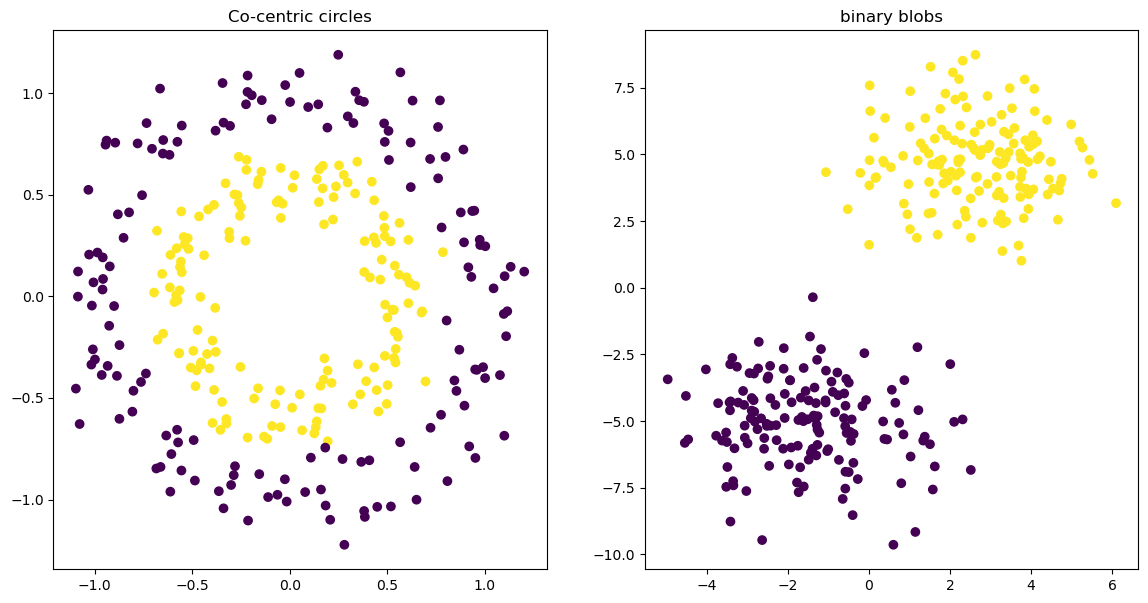

In [2]:
%matplotlib inline
# Do not modify this cell
circles = data.Circles()
binary_blobs = data.DataBlobs(centers=2, std=1.5)

fig, axs = plt.subplots(1, 2)
fig.set_figheight(7), fig.set_figwidth(14)
for i, (dataset, name) in enumerate([(circles, "Co-centric circles"),
                                     (binary_blobs, "binary blobs")]):
    axs[i].set_title(name)
    axs[i].scatter(dataset.X[:, 0], dataset.X[:, 1], c=dataset.labels)
plt.show()



We have seen during the class the dual form of the Support Vector Machine problem using a kernel $K$:

\begin{aligned}
 \max_{\alpha} \sum_i^m \alpha_i &- \frac{1}{2} \sum_{i,j}^m y^{(i)}y^{(j)} \alpha_i \alpha_j K(x^{(i)},x^{(j)})
    \\
      s.t. \text{   } \alpha_i &\geq 0 \\
      \sum_i^m \alpha_i y^{(i)} &= 0
\end{aligned}

The simplest kernel $K$ is the linear kernel 
\begin{align}
K_{lin}(x^{(i)},x^{(j)}) = <x^{(i)}, x^{(j)}>
\end{align}
 with $<.,.>$ being the scalar product.

 We'll be also using the radial kernel $K_{rad}$:
\begin{align}
 K_{rad, \gamma}(x^{(i)},x^{(j)})  = \exp \big[-\gamma ||x^{(i)} - x^{(j)}||^2]
\end{align}
And the polynomial kernel $K_{poly, c, p}$:
\begin{align}
 K_{poly, c, p}(x^{(i)},x^{(j)})  = (<x^{(i)}, x^{(j)}> + c)^p
\end{align}

- **Q1.1 [10 pts]** Complete the implementation of the three kernels defined above

In [3]:
from sklearn.metrics.pairwise import euclidean_distances

class LinearKernel(object):
    def compute(self, x1, x2):
        """
        Compute the kernel matrix
        @param x1: array of shape (m1,p)
        @param x2: array of shape(m2,p)
        @return: K of shape (m1,m2) where K[i,j] = <x1[i], x2[j]>
        """
        K = np.dot(x1, x2.T)
        return K


class RadialKernel(object):

    def __init__(self, gamma):
        self.gamma = gamma

    def compute(self, x1, x2):
        """
        Compute the kernel matrix. Hint: computing the squared distances is similar to compute_distances in K-means
        @param x1: array of shape (m1,p)
        @param x2: array of shape(m2,p)
        @return: K of shape (m1,m2) where K[i,j] = K_rad(x1[i],x2[j]) = exp(-gamma * ||x1[i] - x2[j]||^2)
        """
        x1 = np.atleast_2d(x1)
        x2 = np.atleast_2d(x2)
        m1 = x1.shape[0]
        m2 = x2.shape[0]
        sq_dists = np.zeros((m1, m2))
        for i in range(m1):
            for j in range(m2):
                sq_dists[i, j] = np.sum(np.square(x1[i] - x2[j]))
        K = np.exp(-self.gamma * sq_dists)
        return K



class PolynomialKernel(object):

    def __init__(self, c, p):
        self.c = c
        self.p = p

    def compute(self, x1, x2):
        """
        Compute the kernel matrix.
        @param x1: array of shape (m1,p)
        @param x2: array of shape(m2,p)
        @return: K of shape (m1,m2) where K[i,j] = (x1[i].x2[j] + c)^p
        """
        K = (np.dot(x1, x2.T) + self.c) ** self.p
        return K


In [4]:
%run -i tests kernels

...
----------------------------------------------------------------------
Ran 3 tests in 0.004s

OK


<Figure size 640x480 with 0 Axes>

Now we'll solve for $\alpha$ of the dual form  using the quadratic solver from [`cvxopt` package](https://cvxopt.org/userguide/coneprog.html#quadratic-programming).
To match the solver API, we need to rewrite the problem as:

\begin{aligned}
    \min \frac{1}{2} x^TPx + q^Tx
    \\
     s.t. \ Gx \leq h
    \\
    \ Ax = b
\end{aligned}

So we'll define $P, q, G, h, A, b$  as:

\begin{align}
P_{i,j} &= y^{(i)}y^{(j)} K(x^{(i)},x^{(j)}) \text{,  matrix $P$ is of shape $m\times m$}\\
q &= -\overline{1} \text{,  vector of size m} \\
G &= diag(-\overline{1}) = -I_m\text{, diagonal matrix of -1} \\
h &= \overline{0} \text{,  vector of size m} \\
A &= y \text{, the labels vector} \\
b &= 0 \text{, a scalar (not to confuse with the intercept of SVM)}
\end{align}

- **Q1.2 [9 points]** Complete the following `compute_?` functions to return the corresponding arrays $P, q, G, h, A$ and the scalar $b$.


In [5]:
def compute_P(K, y, beta=0.0):
    assert K.shape[0] == K.shape[1]
    assert K.shape[0] == y.shape[0]
    m = K.shape[0]
    P = 0
    # Workspace 1.2.a
    #BEGIN 
    # code here
    P = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            P[i, j] = y[i] * y[j] * K[i, j] + beta * (i == j)
    #END
    return P

def compute_q(m):
    # Workspace 1.2.b
    q = 0
    #BEGIN 
    # code here
    q = -np.ones(m)
    #END
    return q
def compute_G(m):
    # Workspace 1.2.c
    G = 0
    #BEGIN 
    # code here
    G = -np.identity(m)
    #END
    return G

In [6]:
from cvxopt import matrix
from cvxopt import solvers
import numpy as np

solvers.options['show_progress'] = False
solvers.options['abstol'] = 1e-10
solvers.options['reltol'] = 1e-10
solvers.options['feastol'] = 1e-10

def quadratic_solver(K, y, beta=0.0):
    """
    Solve for alpha of the dual problem,
    @param K: Kernel matrix K of shape (m,m)
    @param y: labels array y of shape (m,)
    @param beta: added later for the bonus question
    @return: optimal alphas of shape (m,)
    """
    m = K.shape[0]
    assert np.allclose([-1, 1], np.unique(y))
    P = compute_P(K, y, beta) # shape (m,m)
    q = compute_q(m)  # shape(m,1)
    G = compute_G(m)  # shape(m,m)
    h = np.zeros(m)  #shape (m,)
    A = y.reshape(1, -1)  # shape (1,m)
    b = 0.0  # scalar
    sol = solvers.qp(P=matrix(P.astype(float)),
                     q=matrix(q.astype(float)),
                     G=matrix(G.astype(float)),
                     h=matrix(h.astype(float)),
                     A=matrix(A.astype(float)),
                     b=matrix(b))
    alphas = np.array(sol['x'])
    alphas = alphas * (np.abs(alphas) > 1e-8)  # zeroing out the small values
    return alphas.reshape(-1)

Once we get the optimal $\alpha$, then we can get the indices of the support vectors $S = \{i | \alpha_i >0 \}$. The intercept $b$ is computed as:

\begin{align}
b = \frac{1}{|S|}\sum_{m\in S}\big[ y^{(m)} - \sum_{i\in S} \alpha_i  y^{(i)}K(x^{(i)}, x^{(m)})\big],
\end{align}
(we only sum over the support vectors, i.e for which $\alpha>0$)


- **Q1.3 [8 points]** Complete the `compute_intercept` to return the intercept value given $y, K, (\alpha_i)_i$


In [7]:
def compute_intercept(K, alphas, y):

    assert alphas.shape == y.shape
    intercept = 0
    # Workspace 1.3
    #BEGIN 
    # code here
    # Compute support vector indices
    support_vector_indices = (alphas > 1e-6)
    if np.sum(support_vector_indices) > 0:
        # Get support vector alphas and labels
        support_vector_alphas = alphas[support_vector_indices]
        support_vector_y = y[support_vector_indices]
        # Get support vector kernel matrix
        support_vector_K = K[support_vector_indices][:, support_vector_indices]
        # Compute dot products of kernel matrix and labels/alphas
        support_vector_K_y = np.dot(support_vector_K, support_vector_y)
        support_vector_K_alpha_y = np.dot(support_vector_K, support_vector_alphas * support_vector_y)
        # Compute intercept using support vectors
        intercept = np.mean(support_vector_y - support_vector_K_alpha_y / support_vector_K_y)
    #END

    return intercept

The predicted label a point $x$ would be:

\begin{align}
\hat{y} = \text{sign}\big[\sum_i y^{(i)}\alpha_i K(x,x^{(i)}) + b \big],
\end{align}
The sum is originally over the support vectors, since for non-support vectors $\alpha=0$ we can sum over the entire training data.

You can see that we only need access to the kernel $K$ and the model is oblivious to the features themselves. That's the power of kernel methods!


- **Q1.4 [6 points]** Complete the `predict` method to return the predicted labels of the provided points.

Since our SVM is making predictions of [-1, 1] but convention expects labels of [0,1], we should report out our results in [0,1] format.

In [8]:
class SVM(object):

    def __init__(self, kernel, beta=0.0):
        self.kernel = kernel
        self.X = None
        self.y = None
        self.intercept = None
        self.alphas = None
        self.beta = beta  # ridge regularization coefficient

    def fit(self, X, y):
        """
        Transform y to (-1,1) and use self.kernel to compute K
        Solve for alphas and compute the intercept using the provided expression
        Keep track of X and y since you'll need them for the prediction
        @param X: data points of shape (m,p)
        @param y: (0,1) labels of shape (m,)
        @return: None
        """
        self.X = X
        self.y = 2 * y - 1
        K = self.kernel.compute(X, X)
        self.alphas = quadratic_solver(K, self.y, self.beta)
        self.intercept = compute_intercept(K, self.alphas, self.y)

    def predict(self, X):
        """
        Predict the labels of points in X
        @param X: data points of shape (m,p)
        @return: predicted 0-1 labels of shape (m,)
        """
        # Workspace 1.4
        predicted_labels = np.zeros((X.shape[0],))
        #BEGIN 
        # code here
        for i in range(X.shape[0]):
            kernel_values = self.kernel.compute(X[i], self.X)
            predicted_labels[i] = np.sign(np.sum(self.alphas * self.y * kernel_values) + self.intercept)
    
        # convert from {-1, 1} labels to {0, 1} labels
        predicted_labels = (predicted_labels + 1) / 2
        #END
        # checking if the labels are in {0, 1}
        assert np.allclose(0.5, np.abs(0.5-np.unique(predicted_labels)))
        
        return predicted_labels

We provide below an example of the expected plots for this problem using the linear kernel. 

- **Q1.5 [4 points]** Edit the cell to report the accuracy on the test sets for each of the two datasets visualized in the plots. How do you explain the obtained accuracies?

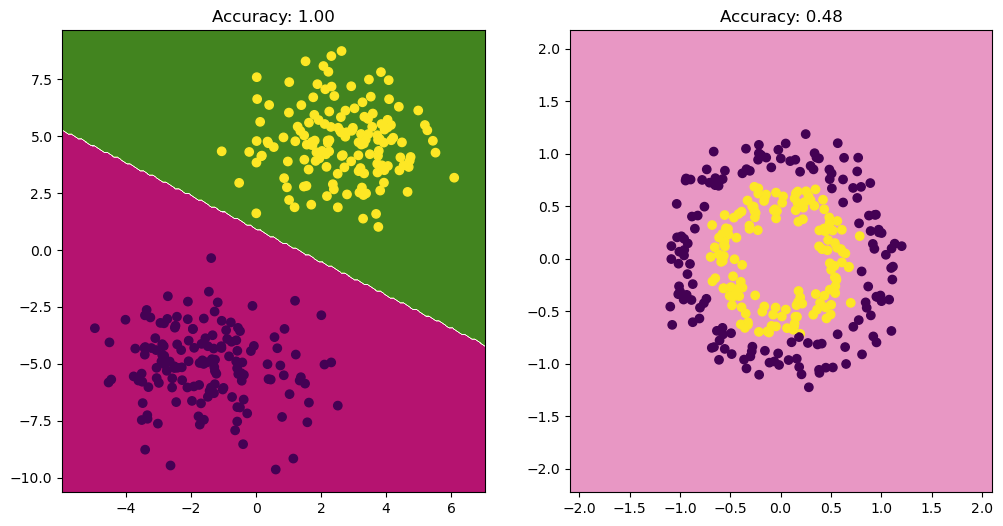

In [9]:
%matplotlib inline
fig, axs = plt.subplots(1, 2)
fig.set_figheight(6), fig.set_figwidth(12)
# Workspace 1.5.a
svm_linear = SVM(LinearKernel())
for i, dataset in enumerate([binary_blobs, circles]):
    svm_linear.fit(dataset.X_train, dataset.y_train)
    helpers.show_decision_surface(svm_linear, dataset.X, dataset.labels, axs[i])
    # Compute and print the accuracy, you can use axs[i].set_title to show it on the plot
    #BEGIN 
    # code here
    predicted_labels = svm_linear.predict(dataset.X_test)
    accuracy = np.mean(predicted_labels == dataset.y_test)
    axs[i].set_title(f"Accuracy: {accuracy:.2f}")
    #END
plt.show()

### Workspace 1.5.b
% Explain the observed performance

#BEGIN

The linear kernel perfectly separates the binary blobs but has no power whatsoever to separate the circle blobs because it can only form a linear decision boundary.

#END

- **Q1.6 [3 points]** Plot and report SVM performance the radial kernel with $\gamma=2.0$. Describe the model performance and compare it to the linear kernel.

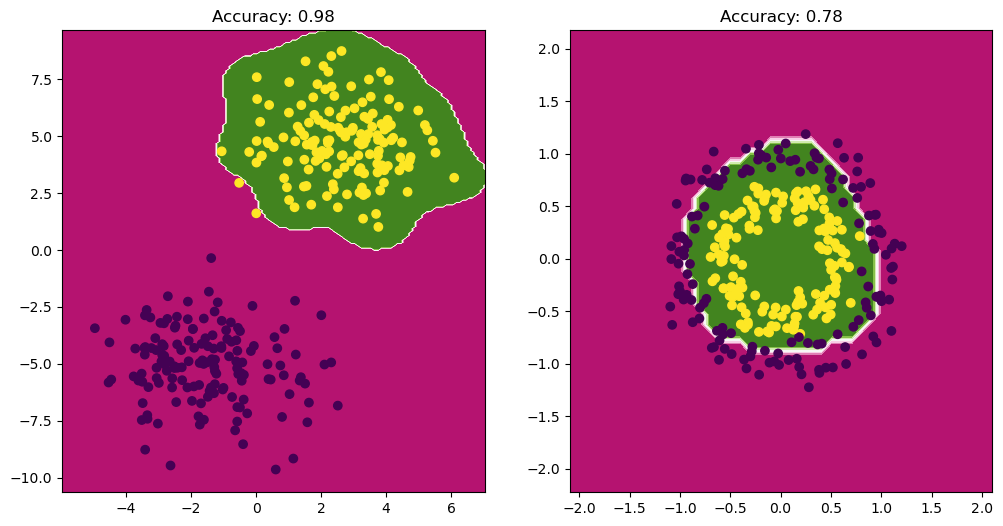

In [11]:
%matplotlib inline
fig, axs = plt.subplots(1, 2)
fig.set_figheight(6), fig.set_figwidth(12)
#Workspace 1.6.a
#BEGIN 
# code here
svm_radial = SVM(RadialKernel(gamma=1.0)) #Gamma was originally 2 but that didn't work on the circles
for i, dataset in enumerate([binary_blobs, circles]):
    svm_radial.fit(dataset.X_train, dataset.y_train)
    helpers.show_decision_surface(svm_radial, dataset.X, dataset.labels, axs[i])
    # Compute and print the accuracy, you can use axs[i].set_title to show it on the plot
    predicted_labels = svm_radial.predict(dataset.X_test)
    accuracy = np.mean(predicted_labels == dataset.y_test)
    axs[i].set_title(f"Accuracy: {accuracy:.2f}")
plt.show()
#END

### Workspace 1.6.b
% Explain the observed performance

#BEGIN

The radial kernel has very good accuracy on the binary blobs like the linear kernel but the decision boundary is a blob around the yellow points and the rest purple because the radial kernel is based on the euclidean distnaces between points rather than finding a line. It's barely able to do better than the linear kernel on the circles data, which we would not expect for the radial kernel. However, changing gamma to 1 instead of 2 increases the accuracy to 0.78 and creates a much more sensible decision boundary.

#END

- **Q1.7 [3 points]** Plot and report SVM performance on the same datasets as in 2.5 using the polynomial kernel with $(c,p) = (1,5)$. Describe the model performance and compare it to the two previous kernels

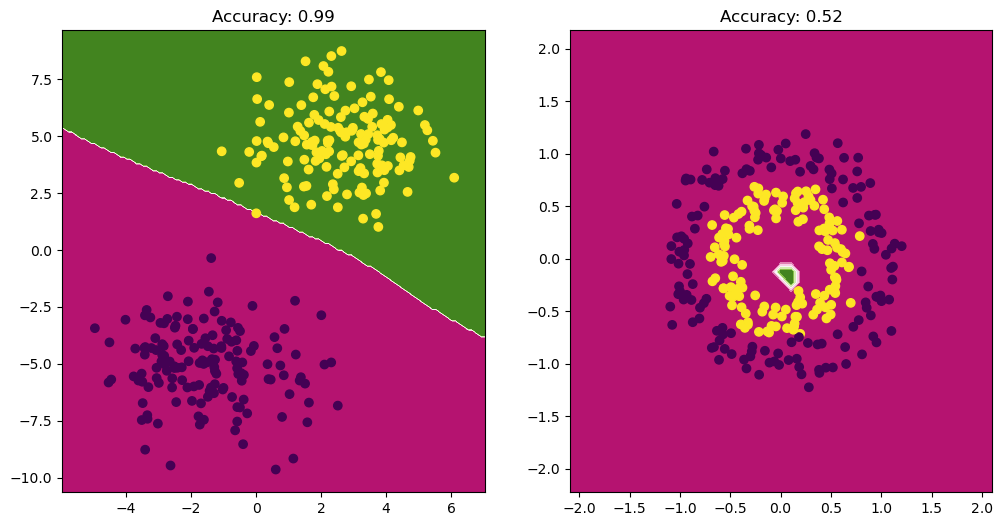

In [123]:
%matplotlib inline
fig, axs = plt.subplots(1, 2)
fig.set_figheight(6), fig.set_figwidth(12)
#Workspace 1.7.a
#BEGIN 
# code here
svm_poly = SVM(PolynomialKernel(c=1,p=5)) 
for i, dataset in enumerate([binary_blobs, circles]):
    svm_poly.fit(dataset.X_train, dataset.y_train)
    helpers.show_decision_surface(svm_poly, dataset.X, dataset.labels, axs[i])
    # Compute and print the accuracy, you can use axs[i].set_title to show it on the plot
    predicted_labels = svm_poly.predict(dataset.X_test)
    accuracy = np.mean(predicted_labels == dataset.y_test)
    axs[i].set_title(f"Accuracy: {accuracy:.2f}")
plt.show()
#END

#BEGIN

The polynomial kernel creates a decision boundary that's very close to linear with near perfect accuracy for the binary blobs and is unable to predict the circles to any useful degree. Its accuracy scores are in between those of the other two for both data sets, with the linear kernel performing best on the binary blobs and worst on the cricles and vice versa for the radial kernel.

#END

### Regularization (4 Bonus pts)

We add a ridge regularization of $\alpha$ with coefficient $\beta$, this time there is a minus $-$ since we're maximizing (so that $\beta ||\alpha||^2$ is minimized).
\begin{aligned}
 \max_{\alpha} \Big[ \sum_i^m \alpha_i &- \frac{1}{2} \sum_{i,j}^m y^{(i)}y^{(j)} \alpha_i \alpha_j K(x^{(i)},x^{(j)}) - \frac{\beta}{2} ||\alpha||^2 \Big]
    \\
      s.t. \text{   } \alpha_i &\geq 0 \\
      \sum_i^m \alpha_i y^{(i)} &= 0
\end{aligned}

**1.8 [Bonus, 6pts]** Which elements of the quadratic system $P, q, G, h, A, b$ do we have to Change? Edit **Q1.2** and `SVM` to incorporate `beta` argument.

To add a ridge regularization term, we change P by adding beta to each entry in the matrix along the diagonal.

## Problem 2: SVM for Multiclass Classification (32 Points)
***
You will now create a classifier that is commonly referred to as _One Versus All_ ([SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)), where a binary classifier will be trained to identify a single class. The prediction is performed by assigning the label
of the classifier that is most confident in its prediction.

The dataset will be the same one we use in Problem Set 1's KNNClassifier.

Note that the constant $\beta$ in *1.8* is slightly different from  $C$  in [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) and make sure to use the flag `probability` to be able to use `predict_proba`

In [31]:
digits = data.Digits()

- **Q2.1 [5 pts]** Complete `one_hot_encoding` to transform your integer labels into a set of binary features via one-hot encoding.
You can assume that it's called after `label_to_index` and `index_to_label` have been defined.


- **Q2.2 [4 pts]** Complete `normalize_data` to normalize your features. You can use `StandardScaler`

- **Q2.3 [6 pts]** Complete `fit` function to fit all classifiers with their corresponding labels and compute the WAR at the end of each epoch

- **Q2.4 [5 pts]** Complete `predict` method to return the predicted label using the scores from each class classifier.
You might be tempted to call `SVC.predict`, but you need to use `predict_proba` to determine the likelihoods.

- **Q2.5 [3 pts]** Complete `score` to return the weighted average recall (WAR) on the validation data (use `recall_score`)


Reminder: make no assumption about the number of features/classes in the data.

In [34]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score


class OneVersusAll(object):

    def __init__(self, beta=0):
        self.classifiers = []  # Array of LogisticRegression classifiers
        self.beta = beta  # regularization / penalty rate (USED IN BONUS)
        self.scaler = StandardScaler()
        self.num_classes = None
        self.fitted = False  # Flag to store whether the scaler is fit

    def one_hot_encoding(self, y):
        """
        Create one-hot encoding of y
        :param y: shape (num_samples,)
        :return: one hot encoding (num_samples, C) where C is the number of classes in the training labels
        """
        one_hot_encode = np.zeros((y.shape[0], len(self.label_to_index)), dtype=int)
        for i, label in enumerate(y):
            one_hot_encode[i, self.label_to_index[label]] = 1
        return one_hot_encode

    def normalize_data(self, X):
        """
        Fit scaler if it hasn't been done yet and normalize X
        :param X: Raw features, shape (num_samples, num_features)
        :return: Normalized features,  shape (num_samples, num_features)
        """
        if not self.fitted:
            self.scaler.fit(X)
            self.fitted = True
        return self.scaler.transform(X)

    def fit(self, X, y):
        """
        Similar to LogisticRegression, but for multiclass case
        :return: metrics, containing WAR score at the end of each epoch on the validation data
        """
        self.num_classes = np.unique(y).shape[0]
        self.label_to_index = dict(zip(np.unique(y), range(len(np.unique(y)))))
        self.index_to_label = {v: k for k, v in self.label_to_index.items()}

        metrics = []

        for epoch in range(10):  # For simplicity we are just going to do 10 epochs
            X_normalized = self.normalize_data(X)
            y_encoded = self.one_hot_encoding(y)

            for i in range(self.num_classes):
                classifier = SVC(probability=True, C=1/self.beta)
                y_i = y == self.index_to_label[i]
                classifier.fit(X_normalized, y_i)
                self.classifiers.append(classifier)

            y_pred = self.predict(X)
            war = recall_score(y, y_pred, average='weighted')
            metrics.append(war)

        return metrics
    
    def predict(self, X):
        """
        The usual predict method
        """
        X_normalized = self.normalize_data(X)
        scores = np.zeros((X_normalized.shape[0], self.num_classes))
        for i in range(self.num_classes):
            probas = self.classifiers[i].predict_proba(X_normalized)[:, 1]
            scores[:, i] = probas
        y_pred = np.argmax(scores, axis=1)
        y_pred = np.array([self.index_to_label[i] for i in y_pred])
        return y_pred

    def score(self, test_x, test_y):
        y_pred = self.predict(test_x)
        war = recall_score(test_y, y_pred, average='weighted')
        return war



- **Q2.6 [5pts]** Plot the curve of accuracy on the training data and the test data as $beta$ varies in a log scale.

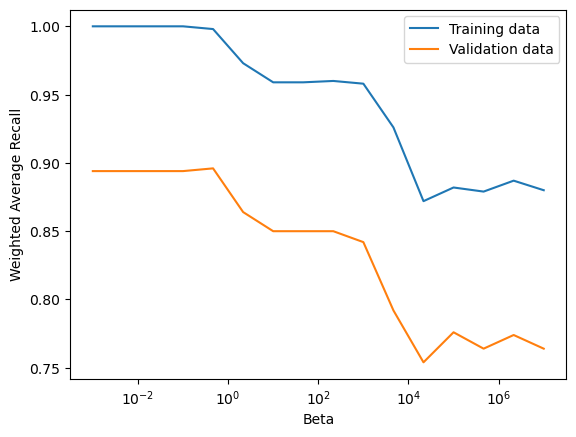

In [36]:
betas = np.logspace(-3, 7, 16)
wars = {"train": [], "valid":[]}
# Workspace 2.4
#BEGIN 
# code here
for beta in betas:
    classifier = OneVersusAll(beta=beta)
    classifier.fit(digits.X_train, digits.y_train)
    
    # Compute the WAR score on the training data
    war_train = classifier.score(digits.X_train,digits.y_train)
    wars["train"].append(war_train)
    
    # Compute the WAR score on the validation data
    war_test = classifier.score(digits.X_test,digits.y_test)
    wars["valid"].append(war_test)

# Plot the WAR scores as a function of beta
plt.semilogx(betas, wars["train"], label="Training data")
plt.semilogx(betas, wars["valid"], label="Validation data")
plt.xlabel("Beta")
plt.ylabel("Weighted Average Recall")
plt.legend()
plt.show()
#END

**Q2.7 [4pts]** What's the relation between $\beta$ and SVC's $C$?

In [ ]:
#BEGIN 
# code here
#END

#### Workspace 2.7

#BEGIN

Beta represents the strength of the regularization. Higher values of C result in better accuracy on the training set but a smaller margin, so C is the inverse of beta. We can see in the previous plot that accuracy decreases as beta increases.

#END

**Q2.8 [3pts]** What's the relation between $\beta$ and SVC's $C$?

#### Workspace 2.8

#BEGIN

Beta represents the strength of the regularization. Higher values of C result in better accuracy on the training set but a smaller margin, so C is the inverse of beta. We can see in the previous plot that accuracy decreases as beta increases.

#END

## Problem 3: Feature Engineering (22 points)
So far in all previous problems, we didn't have to worry about creating the features, that is our `X`. We always relied on having it handed to us.
In practical machine learning problems, however, you will have to do some feature engineering yourself in order to get the features matrix `X` before feeding it to the classifier.

For this problem you will work on extracting features from raw data. You will then use scikit-learn [`SGDClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) to complete the classification task.

We will start by importing some libraries and loading our data which contains 2,000 reviews from IMDB along with their sentiment, either positive (`1`) or negative (`0`).

In [40]:
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [41]:
imdb = data.IMDB()
print(f"[Example: {imdb.X_train[1][:157]}], label:{imdb.y_train[1]}")

[Example: underrated movies are a common reoccurrence in show business today . 1998's 'hope floats' was extremely underrated and was one of the best movies of the year], label:1


Let's call _Featurizer_ any class that is implemented like `StandardScaler` and our initial `MinMaxScaler`. It has:
- a `fit` method that computes any necessary statistics based on our training data (like mean, min or max)
- a `transform` method that generates new features based on given input and the pre-computed statistics
- a `fit_transform` method that combines the two previous methods

We can also combine multiple _Featurizers_ either in a series using [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html):
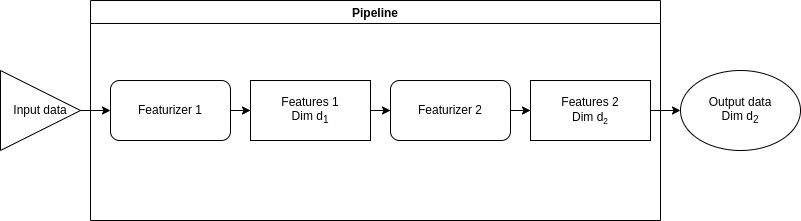
Or in parallel using [`FeatureUnion`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html)

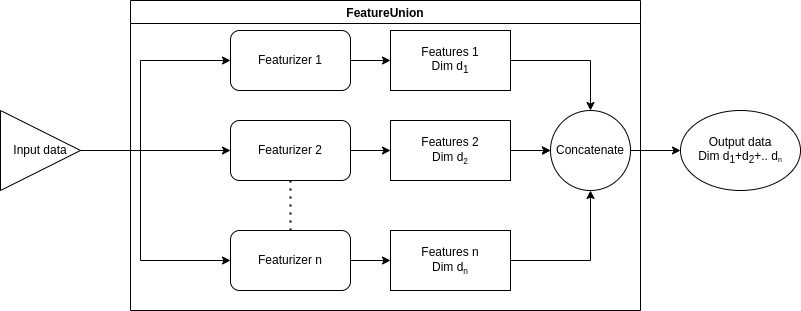

`Pipeline` and `FeatureUnion` are also _Featurizers_.

Both `Pipeline` and `FeatureUnion` take a list of tuples formated as `(features_name: str, featurizer_instance: object)`.

Let's start by extracting some simple features such as the number of sentences in each review.
To do that, we will create a custom scikit-learn feature transformer which will take data as input and returns a feature vector as output.

The feature transformer class has a constructor, a `fit` method. The constructor can be used to store any words or other data that we might need during the feature extraction process.
Feature transformers usually don't need to be fitted, so we will leave that as it is. Most of the work will be done inside the `transform` function.

- **Q3.1 [3 pts]** Complete the `SentenceCounter` class to extract the number of sentences in each review. 
- **Q3.2 [3 pts]** Complete the `PunctCounter` class to count the number of "!" and "?" in each review


In [46]:
class SentenceCounter(BaseEstimator, TransformerMixin):
    """
    A custom feature transformer to extract the number of sentences
    """
    def fit(self, data):
        return self

    def transform(self, data):
        """
        :param data: raw data, of length (num_samples,), where each element is a string 
        :return: features array of shape (num_samples, 1)
        """
        features = np.zeros((len(data), 1))
        # Workspace 3.1
        # TODO: Transform reviews into the feature (number of sentences)  
        #BEGIN 
        # code here
        for i, text in enumerate(data):
            num_sentences = 0
            for char in text:
                if char in ['.', '!', '?']:
                    num_sentences += 1
            features[i] = num_sentences
        #END
        return features


class PunctCounter(SentenceCounter):
    """
    A custom feature transformer to extract the number of "!" and "?"
    """

    def transform(self, data):
        """
        :param data: raw data, of length (num_samples,), where each element is a string 
        :return: features array of shape (num_samples, 1)
        """
        features = np.zeros((len(data), 1))
        # Workspace 3.2
        # TODO: Transform reviews into the feature (number of "!" and "?")  
        #BEGIN 
        # code here
        for i, text in enumerate(data):
            num_puncts = 0
            for char in text:
                if char in ['!', '?']:
                    num_puncts += 1
            features[i] = num_puncts
        #END
        return features

The `featurizer` instance below combines `FeatureUnion` and `Pipeline` operations. First, we extract the number of sentences and number of uppercased words, then normalize the two features.

In [47]:
featurizer = Pipeline([("counts", FeatureUnion([('sentences_count', SentenceCounter()),
                                                ('punct_count', PunctCounter())])),
                       ("normalizer", StandardScaler())])
X_train = featurizer.fit_transform(imdb.X_train)
X_test = featurizer.transform(imdb.X_test)
print(f"means:{np.mean(X_train,axis=0)}, Standard deviations:{np.std(X_train, axis=0)}")
print(X_train.shape, X_test.shape)

means:[9.31001308e-17 2.52179230e-17], Standard deviations:[1. 1.]
(1400, 2) (600, 2)


Let's see how well this simple feature would help us distinguish positive reviews from negative ones.

In [48]:
# Train the classifier and find the accuracy on the test dataset
lr = SGDClassifier(loss='log', penalty='l2', alpha=0.001, max_iter=2000, shuffle=True, verbose=0, random_state=42)
lr.fit(X_train, imdb.y_train)
y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_pred, imdb.y_test)
print("Accuracy on testing set: ", accuracy)

Accuracy on testing set:  0.5383333333333333


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Not that helpful!

Well, that was expected! let's create more transformers to extract more valuable features.  

- **Q3.3 [4 pts]** Complete the `NegativeCounter` feature transformer to extract the number of negative words (vocabulary is provided) 

- **Q3.4 [4 pts]** Complete the `PositiveCounter` feature transformer to extract the number of positive words (vocabulary is provided)

HINT: Before you match the vocabulary words to the review text, use [`word_tokenize`](https://www.nltk.org/api/nltk.tokenize.html) from `nltk` to convert reviews into tokens. 

In [66]:
class NegativeCounter(SentenceCounter):
    """
    A custom feature transformer to extract the feature "number of negative words" 
    """

    def __init__(self):
        self.neg_words = ["second-rate", "violent", "moronic", "third-rate", "flawed", "juvenile", "boring",
                          "distasteful", "ordinary", "disgusting", "senseless", "static", "brutal", "confused",
                          "disappointing", "bloody", "silly", "tired", "predictable", "stupid", "uninteresting",
                          "weak", "incredibly tiresome", "trite", "uneven", "cliché ridden", "outdated",
                          "dreadful", "bland", "bad", "worst", "waste"]

    def transform(self, data):
        """
        :param data: raw data
        :return: features array of shape (n_samples, 1)
        """
        features = np.zeros((len(data), 1))

        # Workspace 3.3
        # TODO: Transform reviews into the feature (number of negative words)  
        #BEGIN 
        neg_count = []
        for review in data:
            review_str = str(review)
            review_words = word_tokenize(review_str)
            count = 0
            for word in review_words:
                if word.lower() in self.neg_words:
                    count += 1
            neg_count.append(count)
        features = np.array(neg_count).reshape(-1, 1)
        #END

        return features


class PositiveCounter(NegativeCounter):
    """
    A custom feature transformer to extract the feature "number of positive words"
    """

    def __init__(self):
        self.pos_words = ["first-rate", "insightful", "clever", "charming", "comical", "charismatic", "enjoyable",
                          "uproarious", "original", "tender", "hilarious", "absorbing", "sensitive", "riveting",
                          "intriguing", "powerful", "fascinating", "pleasant", "surprising", "dazzling",
                          "imaginative", "legendary", "unpretentious", "love", "wonderful",
                          "best", "great", "superb", "still", "beautiful"]

    def transform(self, data):
        """
        :param data: raw data
        :return: features array of shape (n_samples, 1)
        """
        features = np.zeros((len(data), 1))

        # Workspace 3.4
        # TODO: Transform reviews into the feature (number of positive words)  
        #BEGIN 
        pos_count = []
        for review in data:
            review_str = str(review)
            review_words = word_tokenize(review_str)
            count = 0
            for word in review_words:
                if word.lower() in self.pos_words:
                    count += 1
            pos_count.append(count)
        features = np.array(pos_count).reshape(-1, 1)
        #END
        return features


Let's see now how well the classifier would perform with these features that we just engineered. 

- **Q3.5 [4 pts]** Define `second_featurizer` to combine:`num_of_sentences`, `num_of_negative_words`, `num_of_positive_words`, respectively. 

In [69]:
# Workspace 3.5
#BEGIN 
# code here
second_featurizer = Pipeline([("counts", FeatureUnion([('num_of_sentences', SentenceCounter()),
                                                ('num_of_negative_words', NegativeCounter()),
                                                ('num_of_positive_words', PositiveCounter())])),
                       ("normalizer", StandardScaler())])

#END

In [70]:
X_train = second_featurizer.fit_transform(imdb.X_train)
X_test = second_featurizer.transform(imdb.X_test)
print(X_train.shape, X_test.shape)
# Train the classifier and find the accuracy on the test dataset
lr = SGDClassifier(loss='log', penalty='l2', alpha=0.001, max_iter=2000, shuffle=True, verbose=0, random_state=42)
lr.fit(X_train, imdb.y_train)
y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_pred, imdb.y_test)
print("Accuracy on testing set: ", accuracy)

(1400, 3) (600, 3)
Accuracy on testing set:  0.69


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


That's an improvement! Let's try now to include `n-grams` to the list of features.

`N-grams` are all combinations of n-length tokens in a given text. This can be at word level (`word n-grams`) or character level (`char n-grams`) 

For example, if you have the text: `"The movie was great"` , then for this text:

- `unigrams` (`n=1`) at the word level would be `["The", "movie", "was", "great"]` and 
- `bigrams` (`n=2`) at the word level would be `["The movie", "movie was", "was great"]`

and you can generalize this to `n-grams`.

- **Q3.6 [4 points]** Define `third_featurizer` to add include an N-gram extractor at the word level.

HINT: use the scikit-learn transformer [`CountVectorizer`](
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [71]:
third_featurizer = FeatureUnion([
    # Workspace 3.6
    # TODO: Add the three feature transformers from 3.5 and a fourth one to extract word n-grams of range  1 to 3
    #BEGIN 
    # code here
    ('num_of_sentences', SentenceCounter()),
    ('num_of_negative_words', NegativeCounter()),
    ('num_of_positive_words', PositiveCounter()),
    ('n-grams', CountVectorizer())
    #END
])


Let's now see if adding n-grams helped boost the classifier performance. 

In [72]:
X_train = third_featurizer.fit_transform(imdb.X_train)
X_test = third_featurizer.transform(imdb.X_test)
# Train the classifier and find the accuracy on the test dataset
lr = SGDClassifier(loss='log', penalty='l2', alpha=0.0001, max_iter=2000, shuffle=True, verbose=0, random_state=42)
lr.fit(X_train, imdb.y_train)
y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_pred, imdb.y_test)
print("Accuracy on testing set: ", accuracy)

Accuracy on testing set:  0.825


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


N-grams definitely helped enhance the classifier performance!

- 4.7 **(Bonus)** Try to a achieve better accuracy on IMDB dataset. You're restricted to using SGDClassifier, but you're free to tweak its parameters. You'll get 1 bonus point for each 1% accuracy above 80% that you achieve (rounded-up)!

In [ ]:
# Workspace 3.7
#BEGIN 
# code here
#END